In [33]:
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import os
from pathlib import Path
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [35]:
base_dir = r"C:\Users\user\Desktop\DL"
test_dir  = os.path.join(base_dir, "test")

# Validation and Test transforms for no randomness, cvonsistent evaluation
val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transforms)
class_names = test_dataset.classes
num_classes = len(class_names)  # your class_names list

batch_size = 32 # num_workers=2 for parallel data loading
loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [44]:
def load_model(model_name, num_classes, checkpoint_path):
    if model_name == "resnet50":
        model = models.resnet50(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(weights=None)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    elif model_name == "densenet121":
        model = models.densenet121(weights=None)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    elif model_name == "mobilenet_v2":
        model = models.mobilenet_v3_large(weights=None)
        try:
            num_ftrs = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
        except:
            num_ftrs = model.classifier[0].in_features
            model.classifier[0] = nn.Linear(num_ftrs, num_classes)
    else:
        raise ValueError(f"Model '{model_name}' not supported")

    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [45]:
def evaluate_model(model, loader, class_names):
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {model.__class__.__name__}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()
    
    return acc, f1

In [ ]:
models_checkpoints = {
    "resnet50": "ResNet50_Finetuned_best.pth",
    "efficientnet_b0": "EfficientNet-B0_best.pth",
    "mobilenet_v2": "MobileNetV3-Large_best.pth",
    "densenet121": "final_skin_disease_model.pth",
}


Evaluating resnet50...


C:\Users\user\AppData\Local\Temp\ipykernel_5768\975720766.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location


Classification Report:

                         precision    recall  f1-score   support

      Actinic keratoses       0.89      0.94      0.92        88
             Chickenpox       0.94      0.97      0.96       113
                 Cowpox       0.97      0.98      0.97        99
         Dermatofibroma       1.00      0.76      0.86        25
                   HFMD       0.96      0.99      0.97       242
                Healthy       0.98      0.98      0.98       171
                Measles       0.96      0.98      0.97        83
              Monkeypox       0.99      0.96      0.97       426
Squamous cell carcinoma       0.89      0.88      0.88        64
       Vascular lesions       0.93      1.00      0.96        26

               accuracy                           0.96      1337
              macro avg       0.95      0.94      0.94      1337
           weighted avg       0.96      0.96      0.96      1337



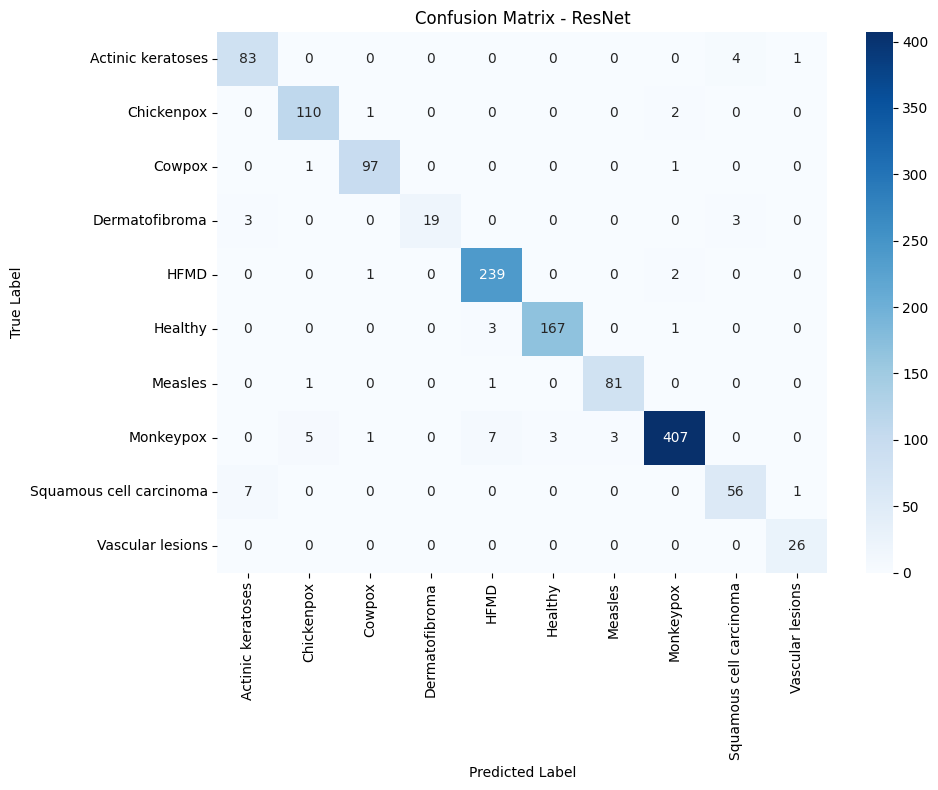


Evaluating efficientnet_b0...


C:\Users\user\AppData\Local\Temp\ipykernel_5768\975720766.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location


Classification Report:

                         precision    recall  f1-score   support

      Actinic keratoses       0.89      0.88      0.88        88
             Chickenpox       0.94      1.00      0.97       113
                 Cowpox       0.98      1.00      0.99        99
         Dermatofibroma       1.00      0.92      0.96        25
                   HFMD       0.99      1.00      0.99       242
                Healthy       0.98      0.99      0.99       171
                Measles       0.98      0.98      0.98        83
              Monkeypox       1.00      0.97      0.98       426
Squamous cell carcinoma       0.84      0.88      0.85        64
       Vascular lesions       1.00      1.00      1.00        26

               accuracy                           0.97      1337
              macro avg       0.96      0.96      0.96      1337
           weighted avg       0.97      0.97      0.97      1337



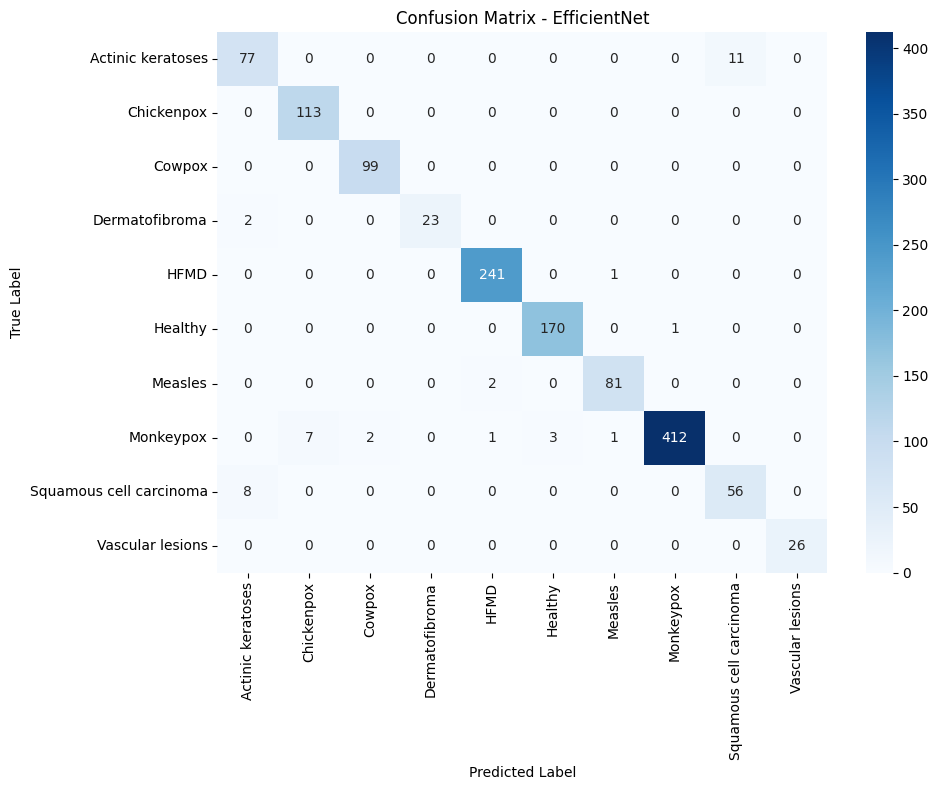


Evaluating mobilenet_v2...


C:\Users\user\AppData\Local\Temp\ipykernel_5768\975720766.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location


Classification Report:

                         precision    recall  f1-score   support

      Actinic keratoses       0.89      0.82      0.85        88
             Chickenpox       0.92      0.98      0.95       113
                 Cowpox       0.99      0.98      0.98        99
         Dermatofibroma       0.95      0.80      0.87        25
                   HFMD       0.95      1.00      0.97       242
                Healthy       1.00      0.95      0.97       171
                Measles       0.96      0.99      0.98        83
              Monkeypox       0.99      0.96      0.98       426
Squamous cell carcinoma       0.78      0.92      0.84        64
       Vascular lesions       1.00      0.96      0.98        26

               accuracy                           0.96      1337
              macro avg       0.94      0.94      0.94      1337
           weighted avg       0.96      0.96      0.96      1337



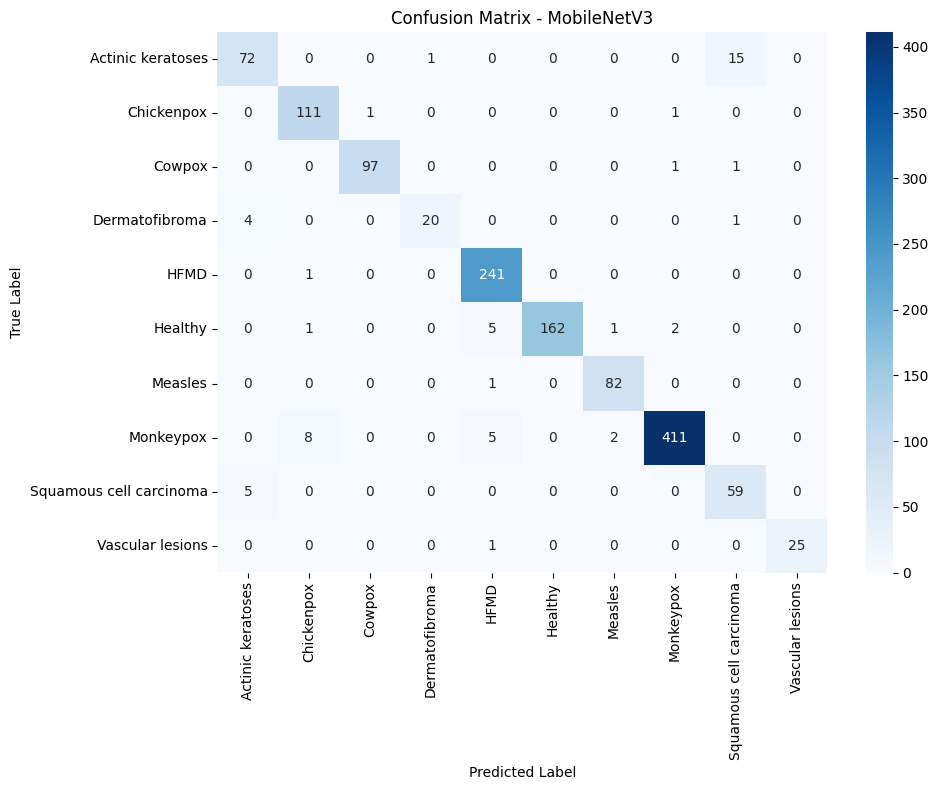


Evaluating densenet121...


C:\Users\user\AppData\Local\Temp\ipykernel_5768\975720766.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location

RuntimeError: Error(s) in loading state_dict for DenseNet:
	Missing key(s) in state_dict: "features.conv0.weight", "features.norm0.weight", "features.norm0.bias", "features.norm0.running_mean", "features.norm0.running_var", "features.denseblock1.denselayer1.norm1.weight", "features.denseblock1.denselayer1.norm1.bias", "features.denseblock1.denselayer1.norm1.running_mean", "features.denseblock1.denselayer1.norm1.running_var", "features.denseblock1.denselayer1.conv1.weight", "features.denseblock1.denselayer1.norm2.weight", "features.denseblock1.denselayer1.norm2.bias", "features.denseblock1.denselayer1.norm2.running_mean", "features.denseblock1.denselayer1.norm2.running_var", "features.denseblock1.denselayer1.conv2.weight", "features.denseblock1.denselayer2.norm1.weight", "features.denseblock1.denselayer2.norm1.bias", "features.denseblock1.denselayer2.norm1.running_mean", "features.denseblock1.denselayer2.norm1.running_var", "features.denseblock1.denselayer2.conv1.weight", "features.denseblock1.denselayer2.norm2.weight", "features.denseblock1.denselayer2.norm2.bias", "features.denseblock1.denselayer2.norm2.running_mean", "features.denseblock1.denselayer2.norm2.running_var", "features.denseblock1.denselayer2.conv2.weight", "features.denseblock1.denselayer3.norm1.weight", "features.denseblock1.denselayer3.norm1.bias", "features.denseblock1.denselayer3.norm1.running_mean", "features.denseblock1.denselayer3.norm1.running_var", "features.denseblock1.denselayer3.conv1.weight", "features.denseblock1.denselayer3.norm2.weight", "features.denseblock1.denselayer3.norm2.bias", "features.denseblock1.denselayer3.norm2.running_mean", "features.denseblock1.denselayer3.norm2.running_var", "features.denseblock1.denselayer3.conv2.weight", "features.denseblock1.denselayer4.norm1.weight", "features.denseblock1.denselayer4.norm1.bias", "features.denseblock1.denselayer4.norm1.running_mean", "features.denseblock1.denselayer4.norm1.running_var", "features.denseblock1.denselayer4.conv1.weight", "features.denseblock1.denselayer4.norm2.weight", "features.denseblock1.denselayer4.norm2.bias", "features.denseblock1.denselayer4.norm2.running_mean", "features.denseblock1.denselayer4.norm2.running_var", "features.denseblock1.denselayer4.conv2.weight", "features.denseblock1.denselayer5.norm1.weight", "features.denseblock1.denselayer5.norm1.bias", "features.denseblock1.denselayer5.norm1.running_mean", "features.denseblock1.denselayer5.norm1.running_var", "features.denseblock1.denselayer5.conv1.weight", "features.denseblock1.denselayer5.norm2.weight", "features.denseblock1.denselayer5.norm2.bias", "features.denseblock1.denselayer5.norm2.running_mean", "features.denseblock1.denselayer5.norm2.running_var", "features.denseblock1.denselayer5.conv2.weight", "features.denseblock1.denselayer6.norm1.weight", "features.denseblock1.denselayer6.norm1.bias", "features.denseblock1.denselayer6.norm1.running_mean", "features.denseblock1.denselayer6.norm1.running_var", "features.denseblock1.denselayer6.conv1.weight", "features.denseblock1.denselayer6.norm2.weight", "features.denseblock1.denselayer6.norm2.bias", "features.denseblock1.denselayer6.norm2.running_mean", "features.denseblock1.denselayer6.norm2.running_var", "features.denseblock1.denselayer6.conv2.weight", "features.transition1.norm.weight", "features.transition1.norm.bias", "features.transition1.norm.running_mean", "features.transition1.norm.running_var", "features.transition1.conv.weight", "features.denseblock2.denselayer1.norm1.weight", "features.denseblock2.denselayer1.norm1.bias", "features.denseblock2.denselayer1.norm1.running_mean", "features.denseblock2.denselayer1.norm1.running_var", "features.denseblock2.denselayer1.conv1.weight", "features.denseblock2.denselayer1.norm2.weight", "features.denseblock2.denselayer1.norm2.bias", "features.denseblock2.denselayer1.norm2.running_mean", "features.denseblock2.denselayer1.norm2.running_var", "features.denseblock2.denselayer1.conv2.weight", "features.denseblock2.denselayer2.norm1.weight", "features.denseblock2.denselayer2.norm1.bias", "features.denseblock2.denselayer2.norm1.running_mean", "features.denseblock2.denselayer2.norm1.running_var", "features.denseblock2.denselayer2.conv1.weight", "features.denseblock2.denselayer2.norm2.weight", "features.denseblock2.denselayer2.norm2.bias", "features.denseblock2.denselayer2.norm2.running_mean", "features.denseblock2.denselayer2.norm2.running_var", "features.denseblock2.denselayer2.conv2.weight", "features.denseblock2.denselayer3.norm1.weight", "features.denseblock2.denselayer3.norm1.bias", "features.denseblock2.denselayer3.norm1.running_mean", "features.denseblock2.denselayer3.norm1.running_var", "features.denseblock2.denselayer3.conv1.weight", "features.denseblock2.denselayer3.norm2.weight", "features.denseblock2.denselayer3.norm2.bias", "features.denseblock2.denselayer3.norm2.running_mean", "features.denseblock2.denselayer3.norm2.running_var", "features.denseblock2.denselayer3.conv2.weight", "features.denseblock2.denselayer4.norm1.weight", "features.denseblock2.denselayer4.norm1.bias", "features.denseblock2.denselayer4.norm1.running_mean", "features.denseblock2.denselayer4.norm1.running_var", "features.denseblock2.denselayer4.conv1.weight", "features.denseblock2.denselayer4.norm2.weight", "features.denseblock2.denselayer4.norm2.bias", "features.denseblock2.denselayer4.norm2.running_mean", "features.denseblock2.denselayer4.norm2.running_var", "features.denseblock2.denselayer4.conv2.weight", "features.denseblock2.denselayer5.norm1.weight", "features.denseblock2.denselayer5.norm1.bias", "features.denseblock2.denselayer5.norm1.running_mean", "features.denseblock2.denselayer5.norm1.running_var", "features.denseblock2.denselayer5.conv1.weight", "features.denseblock2.denselayer5.norm2.weight", "features.denseblock2.denselayer5.norm2.bias", "features.denseblock2.denselayer5.norm2.running_mean", "features.denseblock2.denselayer5.norm2.running_var", "features.denseblock2.denselayer5.conv2.weight", "features.denseblock2.denselayer6.norm1.weight", "features.denseblock2.denselayer6.norm1.bias", "features.denseblock2.denselayer6.norm1.running_mean", "features.denseblock2.denselayer6.norm1.running_var", "features.denseblock2.denselayer6.conv1.weight", "features.denseblock2.denselayer6.norm2.weight", "features.denseblock2.denselayer6.norm2.bias", "features.denseblock2.denselayer6.norm2.running_mean", "features.denseblock2.denselayer6.norm2.running_var", "features.denseblock2.denselayer6.conv2.weight", "features.denseblock2.denselayer7.norm1.weight", "features.denseblock2.denselayer7.norm1.bias", "features.denseblock2.denselayer7.norm1.running_mean", "features.denseblock2.denselayer7.norm1.running_var", "features.denseblock2.denselayer7.conv1.weight", "features.denseblock2.denselayer7.norm2.weight", "features.denseblock2.denselayer7.norm2.bias", "features.denseblock2.denselayer7.norm2.running_mean", "features.denseblock2.denselayer7.norm2.running_var", "features.denseblock2.denselayer7.conv2.weight", "features.denseblock2.denselayer8.norm1.weight", "features.denseblock2.denselayer8.norm1.bias", "features.denseblock2.denselayer8.norm1.running_mean", "features.denseblock2.denselayer8.norm1.running_var", "features.denseblock2.denselayer8.conv1.weight", "features.denseblock2.denselayer8.norm2.weight", "features.denseblock2.denselayer8.norm2.bias", "features.denseblock2.denselayer8.norm2.running_mean", "features.denseblock2.denselayer8.norm2.running_var", "features.denseblock2.denselayer8.conv2.weight", "features.denseblock2.denselayer9.norm1.weight", "features.denseblock2.denselayer9.norm1.bias", "features.denseblock2.denselayer9.norm1.running_mean", "features.denseblock2.denselayer9.norm1.running_var", "features.denseblock2.denselayer9.conv1.weight", "features.denseblock2.denselayer9.norm2.weight", "features.denseblock2.denselayer9.norm2.bias", "features.denseblock2.denselayer9.norm2.running_mean", "features.denseblock2.denselayer9.norm2.running_var", "features.denseblock2.denselayer9.conv2.weight", "features.denseblock2.denselayer10.norm1.weight", "features.denseblock2.denselayer10.norm1.bias", "features.denseblock2.denselayer10.norm1.running_mean", "features.denseblock2.denselayer10.norm1.running_var", "features.denseblock2.denselayer10.conv1.weight", "features.denseblock2.denselayer10.norm2.weight", "features.denseblock2.denselayer10.norm2.bias", "features.denseblock2.denselayer10.norm2.running_mean", "features.denseblock2.denselayer10.norm2.running_var", "features.denseblock2.denselayer10.conv2.weight", "features.denseblock2.denselayer11.norm1.weight", "features.denseblock2.denselayer11.norm1.bias", "features.denseblock2.denselayer11.norm1.running_mean", "features.denseblock2.denselayer11.norm1.running_var", "features.denseblock2.denselayer11.conv1.weight", "features.denseblock2.denselayer11.norm2.weight", "features.denseblock2.denselayer11.norm2.bias", "features.denseblock2.denselayer11.norm2.running_mean", "features.denseblock2.denselayer11.norm2.running_var", "features.denseblock2.denselayer11.conv2.weight", "features.denseblock2.denselayer12.norm1.weight", "features.denseblock2.denselayer12.norm1.bias", "features.denseblock2.denselayer12.norm1.running_mean", "features.denseblock2.denselayer12.norm1.running_var", "features.denseblock2.denselayer12.conv1.weight", "features.denseblock2.denselayer12.norm2.weight", "features.denseblock2.denselayer12.norm2.bias", "features.denseblock2.denselayer12.norm2.running_mean", "features.denseblock2.denselayer12.norm2.running_var", "features.denseblock2.denselayer12.conv2.weight", "features.transition2.norm.weight", "features.transition2.norm.bias", "features.transition2.norm.running_mean", "features.transition2.norm.running_var", "features.transition2.conv.weight", "features.denseblock3.denselayer1.norm1.weight", "features.denseblock3.denselayer1.norm1.bias", "features.denseblock3.denselayer1.norm1.running_mean", "features.denseblock3.denselayer1.norm1.running_var", "features.denseblock3.denselayer1.conv1.weight", "features.denseblock3.denselayer1.norm2.weight", "features.denseblock3.denselayer1.norm2.bias", "features.denseblock3.denselayer1.norm2.running_mean", "features.denseblock3.denselayer1.norm2.running_var", "features.denseblock3.denselayer1.conv2.weight", "features.denseblock3.denselayer2.norm1.weight", "features.denseblock3.denselayer2.norm1.bias", "features.denseblock3.denselayer2.norm1.running_mean", "features.denseblock3.denselayer2.norm1.running_var", "features.denseblock3.denselayer2.conv1.weight", "features.denseblock3.denselayer2.norm2.weight", "features.denseblock3.denselayer2.norm2.bias", "features.denseblock3.denselayer2.norm2.running_mean", "features.denseblock3.denselayer2.norm2.running_var", "features.denseblock3.denselayer2.conv2.weight", "features.denseblock3.denselayer3.norm1.weight", "features.denseblock3.denselayer3.norm1.bias", "features.denseblock3.denselayer3.norm1.running_mean", "features.denseblock3.denselayer3.norm1.running_var", "features.denseblock3.denselayer3.conv1.weight", "features.denseblock3.denselayer3.norm2.weight", "features.denseblock3.denselayer3.norm2.bias", "features.denseblock3.denselayer3.norm2.running_mean", "features.denseblock3.denselayer3.norm2.running_var", "features.denseblock3.denselayer3.conv2.weight", "features.denseblock3.denselayer4.norm1.weight", "features.denseblock3.denselayer4.norm1.bias", "features.denseblock3.denselayer4.norm1.running_mean", "features.denseblock3.denselayer4.norm1.running_var", "features.denseblock3.denselayer4.conv1.weight", "features.denseblock3.denselayer4.norm2.weight", "features.denseblock3.denselayer4.norm2.bias", "features.denseblock3.denselayer4.norm2.running_mean", "features.denseblock3.denselayer4.norm2.running_var", "features.denseblock3.denselayer4.conv2.weight", "features.denseblock3.denselayer5.norm1.weight", "features.denseblock3.denselayer5.norm1.bias", "features.denseblock3.denselayer5.norm1.running_mean", "features.denseblock3.denselayer5.norm1.running_var", "features.denseblock3.denselayer5.conv1.weight", "features.denseblock3.denselayer5.norm2.weight", "features.denseblock3.denselayer5.norm2.bias", "features.denseblock3.denselayer5.norm2.running_mean", "features.denseblock3.denselayer5.norm2.running_var", "features.denseblock3.denselayer5.conv2.weight", "features.denseblock3.denselayer6.norm1.weight", "features.denseblock3.denselayer6.norm1.bias", "features.denseblock3.denselayer6.norm1.running_mean", "features.denseblock3.denselayer6.norm1.running_var", "features.denseblock3.denselayer6.conv1.weight", "features.denseblock3.denselayer6.norm2.weight", "features.denseblock3.denselayer6.norm2.bias", "features.denseblock3.denselayer6.norm2.running_mean", "features.denseblock3.denselayer6.norm2.running_var", "features.denseblock3.denselayer6.conv2.weight", "features.denseblock3.denselayer7.norm1.weight", "features.denseblock3.denselayer7.norm1.bias", "features.denseblock3.denselayer7.norm1.running_mean", "features.denseblock3.denselayer7.norm1.running_var", "features.denseblock3.denselayer7.conv1.weight", "features.denseblock3.denselayer7.norm2.weight", "features.denseblock3.denselayer7.norm2.bias", "features.denseblock3.denselayer7.norm2.running_mean", "features.denseblock3.denselayer7.norm2.running_var", "features.denseblock3.denselayer7.conv2.weight", "features.denseblock3.denselayer8.norm1.weight", "features.denseblock3.denselayer8.norm1.bias", "features.denseblock3.denselayer8.norm1.running_mean", "features.denseblock3.denselayer8.norm1.running_var", "features.denseblock3.denselayer8.conv1.weight", "features.denseblock3.denselayer8.norm2.weight", "features.denseblock3.denselayer8.norm2.bias", "features.denseblock3.denselayer8.norm2.running_mean", "features.denseblock3.denselayer8.norm2.running_var", "features.denseblock3.denselayer8.conv2.weight", "features.denseblock3.denselayer9.norm1.weight", "features.denseblock3.denselayer9.norm1.bias", "features.denseblock3.denselayer9.norm1.running_mean", "features.denseblock3.denselayer9.norm1.running_var", "features.denseblock3.denselayer9.conv1.weight", "features.denseblock3.denselayer9.norm2.weight", "features.denseblock3.denselayer9.norm2.bias", "features.denseblock3.denselayer9.norm2.running_mean", "features.denseblock3.denselayer9.norm2.running_var", "features.denseblock3.denselayer9.conv2.weight", "features.denseblock3.denselayer10.norm1.weight", "features.denseblock3.denselayer10.norm1.bias", "features.denseblock3.denselayer10.norm1.running_mean", "features.denseblock3.denselayer10.norm1.running_var", "features.denseblock3.denselayer10.conv1.weight", "features.denseblock3.denselayer10.norm2.weight", "features.denseblock3.denselayer10.norm2.bias", "features.denseblock3.denselayer10.norm2.running_mean", "features.denseblock3.denselayer10.norm2.running_var", "features.denseblock3.denselayer10.conv2.weight", "features.denseblock3.denselayer11.norm1.weight", "features.denseblock3.denselayer11.norm1.bias", "features.denseblock3.denselayer11.norm1.running_mean", "features.denseblock3.denselayer11.norm1.running_var", "features.denseblock3.denselayer11.conv1.weight", "features.denseblock3.denselayer11.norm2.weight", "features.denseblock3.denselayer11.norm2.bias", "features.denseblock3.denselayer11.norm2.running_mean", "features.denseblock3.denselayer11.norm2.running_var", "features.denseblock3.denselayer11.conv2.weight", "features.denseblock3.denselayer12.norm1.weight", "features.denseblock3.denselayer12.norm1.bias", "features.denseblock3.denselayer12.norm1.running_mean", "features.denseblock3.denselayer12.norm1.running_var", "features.denseblock3.denselayer12.conv1.weight", "features.denseblock3.denselayer12.norm2.weight", "features.denseblock3.denselayer12.norm2.bias", "features.denseblock3.denselayer12.norm2.running_mean", "features.denseblock3.denselayer12.norm2.running_var", "features.denseblock3.denselayer12.conv2.weight", "features.denseblock3.denselayer13.norm1.weight", "features.denseblock3.denselayer13.norm1.bias", "features.denseblock3.denselayer13.norm1.running_mean", "features.denseblock3.denselayer13.norm1.running_var", "features.denseblock3.denselayer13.conv1.weight", "features.denseblock3.denselayer13.norm2.weight", "features.denseblock3.denselayer13.norm2.bias", "features.denseblock3.denselayer13.norm2.running_mean", "features.denseblock3.denselayer13.norm2.running_var", "features.denseblock3.denselayer13.conv2.weight", "features.denseblock3.denselayer14.norm1.weight", "features.denseblock3.denselayer14.norm1.bias", "features.denseblock3.denselayer14.norm1.running_mean", "features.denseblock3.denselayer14.norm1.running_var", "features.denseblock3.denselayer14.conv1.weight", "features.denseblock3.denselayer14.norm2.weight", "features.denseblock3.denselayer14.norm2.bias", "features.denseblock3.denselayer14.norm2.running_mean", "features.denseblock3.denselayer14.norm2.running_var", "features.denseblock3.denselayer14.conv2.weight", "features.denseblock3.denselayer15.norm1.weight", "features.denseblock3.denselayer15.norm1.bias", "features.denseblock3.denselayer15.norm1.running_mean", "features.denseblock3.denselayer15.norm1.running_var", "features.denseblock3.denselayer15.conv1.weight", "features.denseblock3.denselayer15.norm2.weight", "features.denseblock3.denselayer15.norm2.bias", "features.denseblock3.denselayer15.norm2.running_mean", "features.denseblock3.denselayer15.norm2.running_var", "features.denseblock3.denselayer15.conv2.weight", "features.denseblock3.denselayer16.norm1.weight", "features.denseblock3.denselayer16.norm1.bias", "features.denseblock3.denselayer16.norm1.running_mean", "features.denseblock3.denselayer16.norm1.running_var", "features.denseblock3.denselayer16.conv1.weight", "features.denseblock3.denselayer16.norm2.weight", "features.denseblock3.denselayer16.norm2.bias", "features.denseblock3.denselayer16.norm2.running_mean", "features.denseblock3.denselayer16.norm2.running_var", "features.denseblock3.denselayer16.conv2.weight", "features.denseblock3.denselayer17.norm1.weight", "features.denseblock3.denselayer17.norm1.bias", "features.denseblock3.denselayer17.norm1.running_mean", "features.denseblock3.denselayer17.norm1.running_var", "features.denseblock3.denselayer17.conv1.weight", "features.denseblock3.denselayer17.norm2.weight", "features.denseblock3.denselayer17.norm2.bias", "features.denseblock3.denselayer17.norm2.running_mean", "features.denseblock3.denselayer17.norm2.running_var", "features.denseblock3.denselayer17.conv2.weight", "features.denseblock3.denselayer18.norm1.weight", "features.denseblock3.denselayer18.norm1.bias", "features.denseblock3.denselayer18.norm1.running_mean", "features.denseblock3.denselayer18.norm1.running_var", "features.denseblock3.denselayer18.conv1.weight", "features.denseblock3.denselayer18.norm2.weight", "features.denseblock3.denselayer18.norm2.bias", "features.denseblock3.denselayer18.norm2.running_mean", "features.denseblock3.denselayer18.norm2.running_var", "features.denseblock3.denselayer18.conv2.weight", "features.denseblock3.denselayer19.norm1.weight", "features.denseblock3.denselayer19.norm1.bias", "features.denseblock3.denselayer19.norm1.running_mean", "features.denseblock3.denselayer19.norm1.running_var", "features.denseblock3.denselayer19.conv1.weight", "features.denseblock3.denselayer19.norm2.weight", "features.denseblock3.denselayer19.norm2.bias", "features.denseblock3.denselayer19.norm2.running_mean", "features.denseblock3.denselayer19.norm2.running_var", "features.denseblock3.denselayer19.conv2.weight", "features.denseblock3.denselayer20.norm1.weight", "features.denseblock3.denselayer20.norm1.bias", "features.denseblock3.denselayer20.norm1.running_mean", "features.denseblock3.denselayer20.norm1.running_var", "features.denseblock3.denselayer20.conv1.weight", "features.denseblock3.denselayer20.norm2.weight", "features.denseblock3.denselayer20.norm2.bias", "features.denseblock3.denselayer20.norm2.running_mean", "features.denseblock3.denselayer20.norm2.running_var", "features.denseblock3.denselayer20.conv2.weight", "features.denseblock3.denselayer21.norm1.weight", "features.denseblock3.denselayer21.norm1.bias", "features.denseblock3.denselayer21.norm1.running_mean", "features.denseblock3.denselayer21.norm1.running_var", "features.denseblock3.denselayer21.conv1.weight", "features.denseblock3.denselayer21.norm2.weight", "features.denseblock3.denselayer21.norm2.bias", "features.denseblock3.denselayer21.norm2.running_mean", "features.denseblock3.denselayer21.norm2.running_var", "features.denseblock3.denselayer21.conv2.weight", "features.denseblock3.denselayer22.norm1.weight", "features.denseblock3.denselayer22.norm1.bias", "features.denseblock3.denselayer22.norm1.running_mean", "features.denseblock3.denselayer22.norm1.running_var", "features.denseblock3.denselayer22.conv1.weight", "features.denseblock3.denselayer22.norm2.weight", "features.denseblock3.denselayer22.norm2.bias", "features.denseblock3.denselayer22.norm2.running_mean", "features.denseblock3.denselayer22.norm2.running_var", "features.denseblock3.denselayer22.conv2.weight", "features.denseblock3.denselayer23.norm1.weight", "features.denseblock3.denselayer23.norm1.bias", "features.denseblock3.denselayer23.norm1.running_mean", "features.denseblock3.denselayer23.norm1.running_var", "features.denseblock3.denselayer23.conv1.weight", "features.denseblock3.denselayer23.norm2.weight", "features.denseblock3.denselayer23.norm2.bias", "features.denseblock3.denselayer23.norm2.running_mean", "features.denseblock3.denselayer23.norm2.running_var", "features.denseblock3.denselayer23.conv2.weight", "features.denseblock3.denselayer24.norm1.weight", "features.denseblock3.denselayer24.norm1.bias", "features.denseblock3.denselayer24.norm1.running_mean", "features.denseblock3.denselayer24.norm1.running_var", "features.denseblock3.denselayer24.conv1.weight", "features.denseblock3.denselayer24.norm2.weight", "features.denseblock3.denselayer24.norm2.bias", "features.denseblock3.denselayer24.norm2.running_mean", "features.denseblock3.denselayer24.norm2.running_var", "features.denseblock3.denselayer24.conv2.weight", "features.transition3.norm.weight", "features.transition3.norm.bias", "features.transition3.norm.running_mean", "features.transition3.norm.running_var", "features.transition3.conv.weight", "features.denseblock4.denselayer1.norm1.weight", "features.denseblock4.denselayer1.norm1.bias", "features.denseblock4.denselayer1.norm1.running_mean", "features.denseblock4.denselayer1.norm1.running_var", "features.denseblock4.denselayer1.conv1.weight", "features.denseblock4.denselayer1.norm2.weight", "features.denseblock4.denselayer1.norm2.bias", "features.denseblock4.denselayer1.norm2.running_mean", "features.denseblock4.denselayer1.norm2.running_var", "features.denseblock4.denselayer1.conv2.weight", "features.denseblock4.denselayer2.norm1.weight", "features.denseblock4.denselayer2.norm1.bias", "features.denseblock4.denselayer2.norm1.running_mean", "features.denseblock4.denselayer2.norm1.running_var", "features.denseblock4.denselayer2.conv1.weight", "features.denseblock4.denselayer2.norm2.weight", "features.denseblock4.denselayer2.norm2.bias", "features.denseblock4.denselayer2.norm2.running_mean", "features.denseblock4.denselayer2.norm2.running_var", "features.denseblock4.denselayer2.conv2.weight", "features.denseblock4.denselayer3.norm1.weight", "features.denseblock4.denselayer3.norm1.bias", "features.denseblock4.denselayer3.norm1.running_mean", "features.denseblock4.denselayer3.norm1.running_var", "features.denseblock4.denselayer3.conv1.weight", "features.denseblock4.denselayer3.norm2.weight", "features.denseblock4.denselayer3.norm2.bias", "features.denseblock4.denselayer3.norm2.running_mean", "features.denseblock4.denselayer3.norm2.running_var", "features.denseblock4.denselayer3.conv2.weight", "features.denseblock4.denselayer4.norm1.weight", "features.denseblock4.denselayer4.norm1.bias", "features.denseblock4.denselayer4.norm1.running_mean", "features.denseblock4.denselayer4.norm1.running_var", "features.denseblock4.denselayer4.conv1.weight", "features.denseblock4.denselayer4.norm2.weight", "features.denseblock4.denselayer4.norm2.bias", "features.denseblock4.denselayer4.norm2.running_mean", "features.denseblock4.denselayer4.norm2.running_var", "features.denseblock4.denselayer4.conv2.weight", "features.denseblock4.denselayer5.norm1.weight", "features.denseblock4.denselayer5.norm1.bias", "features.denseblock4.denselayer5.norm1.running_mean", "features.denseblock4.denselayer5.norm1.running_var", "features.denseblock4.denselayer5.conv1.weight", "features.denseblock4.denselayer5.norm2.weight", "features.denseblock4.denselayer5.norm2.bias", "features.denseblock4.denselayer5.norm2.running_mean", "features.denseblock4.denselayer5.norm2.running_var", "features.denseblock4.denselayer5.conv2.weight", "features.denseblock4.denselayer6.norm1.weight", "features.denseblock4.denselayer6.norm1.bias", "features.denseblock4.denselayer6.norm1.running_mean", "features.denseblock4.denselayer6.norm1.running_var", "features.denseblock4.denselayer6.conv1.weight", "features.denseblock4.denselayer6.norm2.weight", "features.denseblock4.denselayer6.norm2.bias", "features.denseblock4.denselayer6.norm2.running_mean", "features.denseblock4.denselayer6.norm2.running_var", "features.denseblock4.denselayer6.conv2.weight", "features.denseblock4.denselayer7.norm1.weight", "features.denseblock4.denselayer7.norm1.bias", "features.denseblock4.denselayer7.norm1.running_mean", "features.denseblock4.denselayer7.norm1.running_var", "features.denseblock4.denselayer7.conv1.weight", "features.denseblock4.denselayer7.norm2.weight", "features.denseblock4.denselayer7.norm2.bias", "features.denseblock4.denselayer7.norm2.running_mean", "features.denseblock4.denselayer7.norm2.running_var", "features.denseblock4.denselayer7.conv2.weight", "features.denseblock4.denselayer8.norm1.weight", "features.denseblock4.denselayer8.norm1.bias", "features.denseblock4.denselayer8.norm1.running_mean", "features.denseblock4.denselayer8.norm1.running_var", "features.denseblock4.denselayer8.conv1.weight", "features.denseblock4.denselayer8.norm2.weight", "features.denseblock4.denselayer8.norm2.bias", "features.denseblock4.denselayer8.norm2.running_mean", "features.denseblock4.denselayer8.norm2.running_var", "features.denseblock4.denselayer8.conv2.weight", "features.denseblock4.denselayer9.norm1.weight", "features.denseblock4.denselayer9.norm1.bias", "features.denseblock4.denselayer9.norm1.running_mean", "features.denseblock4.denselayer9.norm1.running_var", "features.denseblock4.denselayer9.conv1.weight", "features.denseblock4.denselayer9.norm2.weight", "features.denseblock4.denselayer9.norm2.bias", "features.denseblock4.denselayer9.norm2.running_mean", "features.denseblock4.denselayer9.norm2.running_var", "features.denseblock4.denselayer9.conv2.weight", "features.denseblock4.denselayer10.norm1.weight", "features.denseblock4.denselayer10.norm1.bias", "features.denseblock4.denselayer10.norm1.running_mean", "features.denseblock4.denselayer10.norm1.running_var", "features.denseblock4.denselayer10.conv1.weight", "features.denseblock4.denselayer10.norm2.weight", "features.denseblock4.denselayer10.norm2.bias", "features.denseblock4.denselayer10.norm2.running_mean", "features.denseblock4.denselayer10.norm2.running_var", "features.denseblock4.denselayer10.conv2.weight", "features.denseblock4.denselayer11.norm1.weight", "features.denseblock4.denselayer11.norm1.bias", "features.denseblock4.denselayer11.norm1.running_mean", "features.denseblock4.denselayer11.norm1.running_var", "features.denseblock4.denselayer11.conv1.weight", "features.denseblock4.denselayer11.norm2.weight", "features.denseblock4.denselayer11.norm2.bias", "features.denseblock4.denselayer11.norm2.running_mean", "features.denseblock4.denselayer11.norm2.running_var", "features.denseblock4.denselayer11.conv2.weight", "features.denseblock4.denselayer12.norm1.weight", "features.denseblock4.denselayer12.norm1.bias", "features.denseblock4.denselayer12.norm1.running_mean", "features.denseblock4.denselayer12.norm1.running_var", "features.denseblock4.denselayer12.conv1.weight", "features.denseblock4.denselayer12.norm2.weight", "features.denseblock4.denselayer12.norm2.bias", "features.denseblock4.denselayer12.norm2.running_mean", "features.denseblock4.denselayer12.norm2.running_var", "features.denseblock4.denselayer12.conv2.weight", "features.denseblock4.denselayer13.norm1.weight", "features.denseblock4.denselayer13.norm1.bias", "features.denseblock4.denselayer13.norm1.running_mean", "features.denseblock4.denselayer13.norm1.running_var", "features.denseblock4.denselayer13.conv1.weight", "features.denseblock4.denselayer13.norm2.weight", "features.denseblock4.denselayer13.norm2.bias", "features.denseblock4.denselayer13.norm2.running_mean", "features.denseblock4.denselayer13.norm2.running_var", "features.denseblock4.denselayer13.conv2.weight", "features.denseblock4.denselayer14.norm1.weight", "features.denseblock4.denselayer14.norm1.bias", "features.denseblock4.denselayer14.norm1.running_mean", "features.denseblock4.denselayer14.norm1.running_var", "features.denseblock4.denselayer14.conv1.weight", "features.denseblock4.denselayer14.norm2.weight", "features.denseblock4.denselayer14.norm2.bias", "features.denseblock4.denselayer14.norm2.running_mean", "features.denseblock4.denselayer14.norm2.running_var", "features.denseblock4.denselayer14.conv2.weight", "features.denseblock4.denselayer15.norm1.weight", "features.denseblock4.denselayer15.norm1.bias", "features.denseblock4.denselayer15.norm1.running_mean", "features.denseblock4.denselayer15.norm1.running_var", "features.denseblock4.denselayer15.conv1.weight", "features.denseblock4.denselayer15.norm2.weight", "features.denseblock4.denselayer15.norm2.bias", "features.denseblock4.denselayer15.norm2.running_mean", "features.denseblock4.denselayer15.norm2.running_var", "features.denseblock4.denselayer15.conv2.weight", "features.denseblock4.denselayer16.norm1.weight", "features.denseblock4.denselayer16.norm1.bias", "features.denseblock4.denselayer16.norm1.running_mean", "features.denseblock4.denselayer16.norm1.running_var", "features.denseblock4.denselayer16.conv1.weight", "features.denseblock4.denselayer16.norm2.weight", "features.denseblock4.denselayer16.norm2.bias", "features.denseblock4.denselayer16.norm2.running_mean", "features.denseblock4.denselayer16.norm2.running_var", "features.denseblock4.denselayer16.conv2.weight", "features.norm5.weight", "features.norm5.bias", "features.norm5.running_mean", "features.norm5.running_var", "classifier.weight", "classifier.bias". 
	Unexpected key(s) in state_dict: "features.0.0.weight", "features.0.1.weight", "features.0.1.bias", "features.0.1.running_mean", "features.0.1.running_var", "features.0.1.num_batches_tracked", "features.1.0.block.0.0.weight", "features.1.0.block.0.1.weight", "features.1.0.block.0.1.bias", "features.1.0.block.0.1.running_mean", "features.1.0.block.0.1.running_var", "features.1.0.block.0.1.num_batches_tracked", "features.1.0.block.1.fc1.weight", "features.1.0.block.1.fc1.bias", "features.1.0.block.1.fc2.weight", "features.1.0.block.1.fc2.bias", "features.1.0.block.2.0.weight", "features.1.0.block.2.1.weight", "features.1.0.block.2.1.bias", "features.1.0.block.2.1.running_mean", "features.1.0.block.2.1.running_var", "features.1.0.block.2.1.num_batches_tracked", "features.2.0.block.0.0.weight", "features.2.0.block.0.1.weight", "features.2.0.block.0.1.bias", "features.2.0.block.0.1.running_mean", "features.2.0.block.0.1.running_var", "features.2.0.block.0.1.num_batches_tracked", "features.2.0.block.1.0.weight", "features.2.0.block.1.1.weight", "features.2.0.block.1.1.bias", "features.2.0.block.1.1.running_mean", "features.2.0.block.1.1.running_var", "features.2.0.block.1.1.num_batches_tracked", "features.2.0.block.2.fc1.weight", "features.2.0.block.2.fc1.bias", "features.2.0.block.2.fc2.weight", "features.2.0.block.2.fc2.bias", "features.2.0.block.3.0.weight", "features.2.0.block.3.1.weight", "features.2.0.block.3.1.bias", "features.2.0.block.3.1.running_mean", "features.2.0.block.3.1.running_var", "features.2.0.block.3.1.num_batches_tracked", "features.2.1.block.0.0.weight", "features.2.1.block.0.1.weight", "features.2.1.block.0.1.bias", "features.2.1.block.0.1.running_mean", "features.2.1.block.0.1.running_var", "features.2.1.block.0.1.num_batches_tracked", "features.2.1.block.1.0.weight", "features.2.1.block.1.1.weight", "features.2.1.block.1.1.bias", "features.2.1.block.1.1.running_mean", "features.2.1.block.1.1.running_var", "features.2.1.block.1.1.num_batches_tracked", "features.2.1.block.2.fc1.weight", "features.2.1.block.2.fc1.bias", "features.2.1.block.2.fc2.weight", "features.2.1.block.2.fc2.bias", "features.2.1.block.3.0.weight", "features.2.1.block.3.1.weight", "features.2.1.block.3.1.bias", "features.2.1.block.3.1.running_mean", "features.2.1.block.3.1.running_var", "features.2.1.block.3.1.num_batches_tracked", "features.3.0.block.0.0.weight", "features.3.0.block.0.1.weight", "features.3.0.block.0.1.bias", "features.3.0.block.0.1.running_mean", "features.3.0.block.0.1.running_var", "features.3.0.block.0.1.num_batches_tracked", "features.3.0.block.1.0.weight", "features.3.0.block.1.1.weight", "features.3.0.block.1.1.bias", "features.3.0.block.1.1.running_mean", "features.3.0.block.1.1.running_var", "features.3.0.block.1.1.num_batches_tracked", "features.3.0.block.2.fc1.weight", "features.3.0.block.2.fc1.bias", "features.3.0.block.2.fc2.weight", "features.3.0.block.2.fc2.bias", "features.3.0.block.3.0.weight", "features.3.0.block.3.1.weight", "features.3.0.block.3.1.bias", "features.3.0.block.3.1.running_mean", "features.3.0.block.3.1.running_var", "features.3.0.block.3.1.num_batches_tracked", "features.3.1.block.0.0.weight", "features.3.1.block.0.1.weight", "features.3.1.block.0.1.bias", "features.3.1.block.0.1.running_mean", "features.3.1.block.0.1.running_var", "features.3.1.block.0.1.num_batches_tracked", "features.3.1.block.1.0.weight", "features.3.1.block.1.1.weight", "features.3.1.block.1.1.bias", "features.3.1.block.1.1.running_mean", "features.3.1.block.1.1.running_var", "features.3.1.block.1.1.num_batches_tracked", "features.3.1.block.2.fc1.weight", "features.3.1.block.2.fc1.bias", "features.3.1.block.2.fc2.weight", "features.3.1.block.2.fc2.bias", "features.3.1.block.3.0.weight", "features.3.1.block.3.1.weight", "features.3.1.block.3.1.bias", "features.3.1.block.3.1.running_mean", "features.3.1.block.3.1.running_var", "features.3.1.block.3.1.num_batches_tracked", "features.4.0.block.0.0.weight", "features.4.0.block.0.1.weight", "features.4.0.block.0.1.bias", "features.4.0.block.0.1.running_mean", "features.4.0.block.0.1.running_var", "features.4.0.block.0.1.num_batches_tracked", "features.4.0.block.1.0.weight", "features.4.0.block.1.1.weight", "features.4.0.block.1.1.bias", "features.4.0.block.1.1.running_mean", "features.4.0.block.1.1.running_var", "features.4.0.block.1.1.num_batches_tracked", "features.4.0.block.2.fc1.weight", "features.4.0.block.2.fc1.bias", "features.4.0.block.2.fc2.weight", "features.4.0.block.2.fc2.bias", "features.4.0.block.3.0.weight", "features.4.0.block.3.1.weight", "features.4.0.block.3.1.bias", "features.4.0.block.3.1.running_mean", "features.4.0.block.3.1.running_var", "features.4.0.block.3.1.num_batches_tracked", "features.4.1.block.0.0.weight", "features.4.1.block.0.1.weight", "features.4.1.block.0.1.bias", "features.4.1.block.0.1.running_mean", "features.4.1.block.0.1.running_var", "features.4.1.block.0.1.num_batches_tracked", "features.4.1.block.1.0.weight", "features.4.1.block.1.1.weight", "features.4.1.block.1.1.bias", "features.4.1.block.1.1.running_mean", "features.4.1.block.1.1.running_var", "features.4.1.block.1.1.num_batches_tracked", "features.4.1.block.2.fc1.weight", "features.4.1.block.2.fc1.bias", "features.4.1.block.2.fc2.weight", "features.4.1.block.2.fc2.bias", "features.4.1.block.3.0.weight", "features.4.1.block.3.1.weight", "features.4.1.block.3.1.bias", "features.4.1.block.3.1.running_mean", "features.4.1.block.3.1.running_var", "features.4.1.block.3.1.num_batches_tracked", "features.4.2.block.0.0.weight", "features.4.2.block.0.1.weight", "features.4.2.block.0.1.bias", "features.4.2.block.0.1.running_mean", "features.4.2.block.0.1.running_var", "features.4.2.block.0.1.num_batches_tracked", "features.4.2.block.1.0.weight", "features.4.2.block.1.1.weight", "features.4.2.block.1.1.bias", "features.4.2.block.1.1.running_mean", "features.4.2.block.1.1.running_var", "features.4.2.block.1.1.num_batches_tracked", "features.4.2.block.2.fc1.weight", "features.4.2.block.2.fc1.bias", "features.4.2.block.2.fc2.weight", "features.4.2.block.2.fc2.bias", "features.4.2.block.3.0.weight", "features.4.2.block.3.1.weight", "features.4.2.block.3.1.bias", "features.4.2.block.3.1.running_mean", "features.4.2.block.3.1.running_var", "features.4.2.block.3.1.num_batches_tracked", "features.5.0.block.0.0.weight", "features.5.0.block.0.1.weight", "features.5.0.block.0.1.bias", "features.5.0.block.0.1.running_mean", "features.5.0.block.0.1.running_var", "features.5.0.block.0.1.num_batches_tracked", "features.5.0.block.1.0.weight", "features.5.0.block.1.1.weight", "features.5.0.block.1.1.bias", "features.5.0.block.1.1.running_mean", "features.5.0.block.1.1.running_var", "features.5.0.block.1.1.num_batches_tracked", "features.5.0.block.2.fc1.weight", "features.5.0.block.2.fc1.bias", "features.5.0.block.2.fc2.weight", "features.5.0.block.2.fc2.bias", "features.5.0.block.3.0.weight", "features.5.0.block.3.1.weight", "features.5.0.block.3.1.bias", "features.5.0.block.3.1.running_mean", "features.5.0.block.3.1.running_var", "features.5.0.block.3.1.num_batches_tracked", "features.5.1.block.0.0.weight", "features.5.1.block.0.1.weight", "features.5.1.block.0.1.bias", "features.5.1.block.0.1.running_mean", "features.5.1.block.0.1.running_var", "features.5.1.block.0.1.num_batches_tracked", "features.5.1.block.1.0.weight", "features.5.1.block.1.1.weight", "features.5.1.block.1.1.bias", "features.5.1.block.1.1.running_mean", "features.5.1.block.1.1.running_var", "features.5.1.block.1.1.num_batches_tracked", "features.5.1.block.2.fc1.weight", "features.5.1.block.2.fc1.bias", "features.5.1.block.2.fc2.weight", "features.5.1.block.2.fc2.bias", "features.5.1.block.3.0.weight", "features.5.1.block.3.1.weight", "features.5.1.block.3.1.bias", "features.5.1.block.3.1.running_mean", "features.5.1.block.3.1.running_var", "features.5.1.block.3.1.num_batches_tracked", "features.5.2.block.0.0.weight", "features.5.2.block.0.1.weight", "features.5.2.block.0.1.bias", "features.5.2.block.0.1.running_mean", "features.5.2.block.0.1.running_var", "features.5.2.block.0.1.num_batches_tracked", "features.5.2.block.1.0.weight", "features.5.2.block.1.1.weight", "features.5.2.block.1.1.bias", "features.5.2.block.1.1.running_mean", "features.5.2.block.1.1.running_var", "features.5.2.block.1.1.num_batches_tracked", "features.5.2.block.2.fc1.weight", "features.5.2.block.2.fc1.bias", "features.5.2.block.2.fc2.weight", "features.5.2.block.2.fc2.bias", "features.5.2.block.3.0.weight", "features.5.2.block.3.1.weight", "features.5.2.block.3.1.bias", "features.5.2.block.3.1.running_mean", "features.5.2.block.3.1.running_var", "features.5.2.block.3.1.num_batches_tracked", "features.6.0.block.0.0.weight", "features.6.0.block.0.1.weight", "features.6.0.block.0.1.bias", "features.6.0.block.0.1.running_mean", "features.6.0.block.0.1.running_var", "features.6.0.block.0.1.num_batches_tracked", "features.6.0.block.1.0.weight", "features.6.0.block.1.1.weight", "features.6.0.block.1.1.bias", "features.6.0.block.1.1.running_mean", "features.6.0.block.1.1.running_var", "features.6.0.block.1.1.num_batches_tracked", "features.6.0.block.2.fc1.weight", "features.6.0.block.2.fc1.bias", "features.6.0.block.2.fc2.weight", "features.6.0.block.2.fc2.bias", "features.6.0.block.3.0.weight", "features.6.0.block.3.1.weight", "features.6.0.block.3.1.bias", "features.6.0.block.3.1.running_mean", "features.6.0.block.3.1.running_var", "features.6.0.block.3.1.num_batches_tracked", "features.6.1.block.0.0.weight", "features.6.1.block.0.1.weight", "features.6.1.block.0.1.bias", "features.6.1.block.0.1.running_mean", "features.6.1.block.0.1.running_var", "features.6.1.block.0.1.num_batches_tracked", "features.6.1.block.1.0.weight", "features.6.1.block.1.1.weight", "features.6.1.block.1.1.bias", "features.6.1.block.1.1.running_mean", "features.6.1.block.1.1.running_var", "features.6.1.block.1.1.num_batches_tracked", "features.6.1.block.2.fc1.weight", "features.6.1.block.2.fc1.bias", "features.6.1.block.2.fc2.weight", "features.6.1.block.2.fc2.bias", "features.6.1.block.3.0.weight", "features.6.1.block.3.1.weight", "features.6.1.block.3.1.bias", "features.6.1.block.3.1.running_mean", "features.6.1.block.3.1.running_var", "features.6.1.block.3.1.num_batches_tracked", "features.6.2.block.0.0.weight", "features.6.2.block.0.1.weight", "features.6.2.block.0.1.bias", "features.6.2.block.0.1.running_mean", "features.6.2.block.0.1.running_var", "features.6.2.block.0.1.num_batches_tracked", "features.6.2.block.1.0.weight", "features.6.2.block.1.1.weight", "features.6.2.block.1.1.bias", "features.6.2.block.1.1.running_mean", "features.6.2.block.1.1.running_var", "features.6.2.block.1.1.num_batches_tracked", "features.6.2.block.2.fc1.weight", "features.6.2.block.2.fc1.bias", "features.6.2.block.2.fc2.weight", "features.6.2.block.2.fc2.bias", "features.6.2.block.3.0.weight", "features.6.2.block.3.1.weight", "features.6.2.block.3.1.bias", "features.6.2.block.3.1.running_mean", "features.6.2.block.3.1.running_var", "features.6.2.block.3.1.num_batches_tracked", "features.6.3.block.0.0.weight", "features.6.3.block.0.1.weight", "features.6.3.block.0.1.bias", "features.6.3.block.0.1.running_mean", "features.6.3.block.0.1.running_var", "features.6.3.block.0.1.num_batches_tracked", "features.6.3.block.1.0.weight", "features.6.3.block.1.1.weight", "features.6.3.block.1.1.bias", "features.6.3.block.1.1.running_mean", "features.6.3.block.1.1.running_var", "features.6.3.block.1.1.num_batches_tracked", "features.6.3.block.2.fc1.weight", "features.6.3.block.2.fc1.bias", "features.6.3.block.2.fc2.weight", "features.6.3.block.2.fc2.bias", "features.6.3.block.3.0.weight", "features.6.3.block.3.1.weight", "features.6.3.block.3.1.bias", "features.6.3.block.3.1.running_mean", "features.6.3.block.3.1.running_var", "features.6.3.block.3.1.num_batches_tracked", "features.7.0.block.0.0.weight", "features.7.0.block.0.1.weight", "features.7.0.block.0.1.bias", "features.7.0.block.0.1.running_mean", "features.7.0.block.0.1.running_var", "features.7.0.block.0.1.num_batches_tracked", "features.7.0.block.1.0.weight", "features.7.0.block.1.1.weight", "features.7.0.block.1.1.bias", "features.7.0.block.1.1.running_mean", "features.7.0.block.1.1.running_var", "features.7.0.block.1.1.num_batches_tracked", "features.7.0.block.2.fc1.weight", "features.7.0.block.2.fc1.bias", "features.7.0.block.2.fc2.weight", "features.7.0.block.2.fc2.bias", "features.7.0.block.3.0.weight", "features.7.0.block.3.1.weight", "features.7.0.block.3.1.bias", "features.7.0.block.3.1.running_mean", "features.7.0.block.3.1.running_var", "features.7.0.block.3.1.num_batches_tracked", "features.8.0.weight", "features.8.1.weight", "features.8.1.bias", "features.8.1.running_mean", "features.8.1.running_var", "features.8.1.num_batches_tracked", "classifier.1.weight", "classifier.1.bias". 

In [47]:
results = {}

for model_name, ckpt in models_checkpoints.items():
    print(f"\nEvaluating {model_name}...")
    model = load_model(model_name, num_classes, ckpt)
    acc, f1 = evaluate_model(model, loader, class_names)
    results[model_name] = {"accuracy": acc, "f1": f1}

names = list(results.keys())
accs = [results[m]["accuracy"] for m in names]
f1s  = [results[m]["f1"] for m in names]

x = np.arange(len(names))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, accs, width, label="Accuracy", alpha=0.7)
plt.bar(x + width/2, f1s, width, label="F1 Score", alpha=0.7)
plt.xticks(x, names)
plt.ylabel("Score")
plt.title("Model Comparison")
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.show()

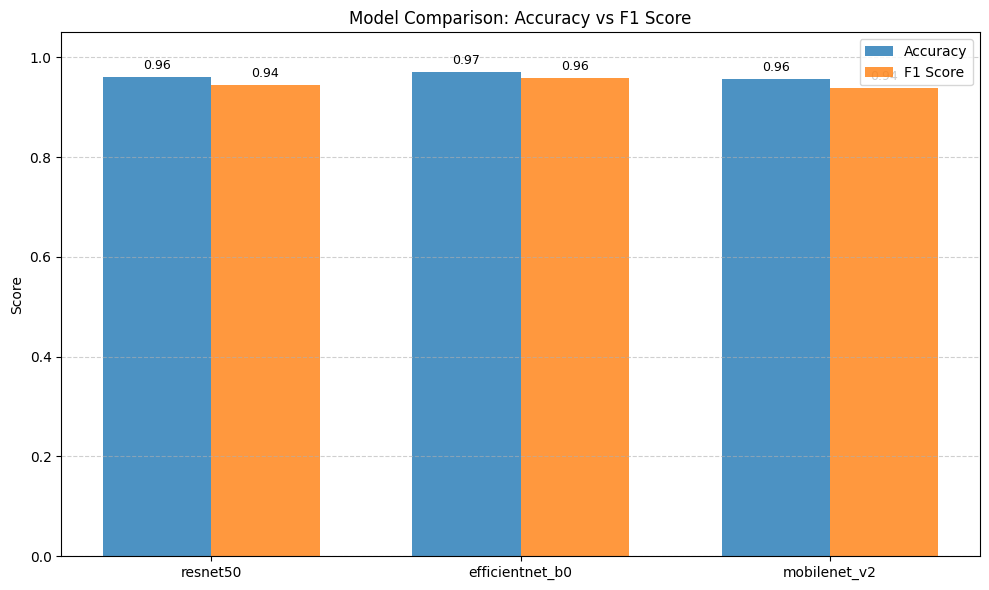

In [49]:
import matplotlib.pyplot as plt
import numpy as np

names = list(results.keys())
accs = [results[m]["accuracy"] for m in names]
f1s  = [results[m]["f1"] for m in names]

x = np.arange(len(names))
width = 0.35

plt.figure(figsize=(10,6))
bars1 = plt.bar(x - width/2, accs, width, label='Accuracy', alpha=0.8)
bars2 = plt.bar(x + width/2, f1s, width, label='F1 Score', alpha=0.8)

# Annotate each bar with its value
for bars in [bars1, bars2]:
    for bar in bars:
        plt.text(
            bar.get_x() + bar.get_width()/2, 
            bar.get_height() + 0.01, 
            f"{bar.get_height():.2f}", 
            ha='center', va='bottom', fontsize=9
        )

plt.xticks(x, names)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy vs F1 Score")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


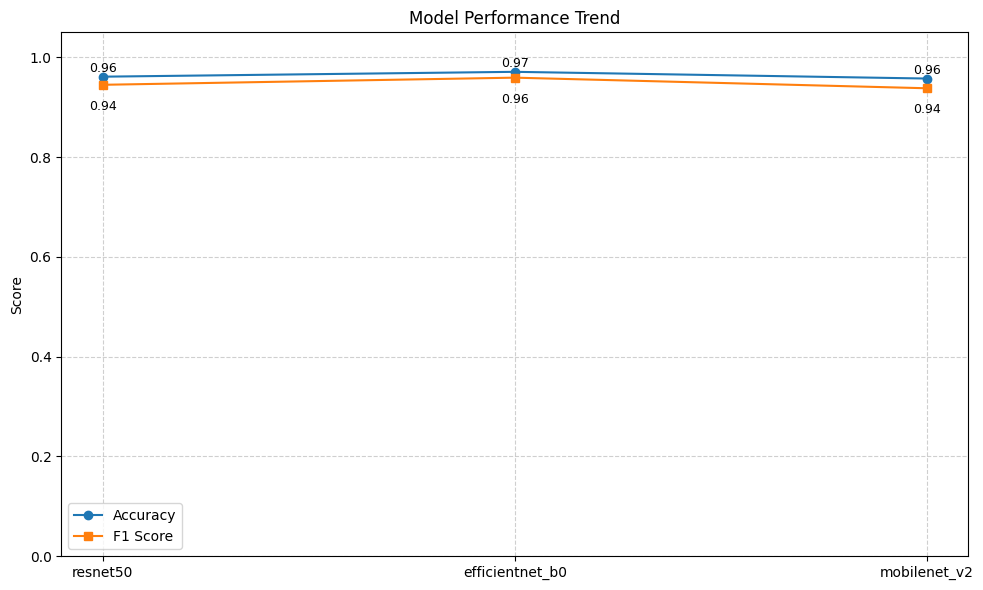

In [50]:
plt.figure(figsize=(10,6))
plt.plot(names, accs, marker='o', label='Accuracy')
plt.plot(names, f1s, marker='s', label='F1 Score')

for i, val in enumerate(accs):
    plt.text(i, val + 0.01, f"{val:.2f}", ha='center', fontsize=9)
for i, val in enumerate(f1s):
    plt.text(i, val - 0.05, f"{val:.2f}", ha='center', fontsize=9)

plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Model Performance Trend")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


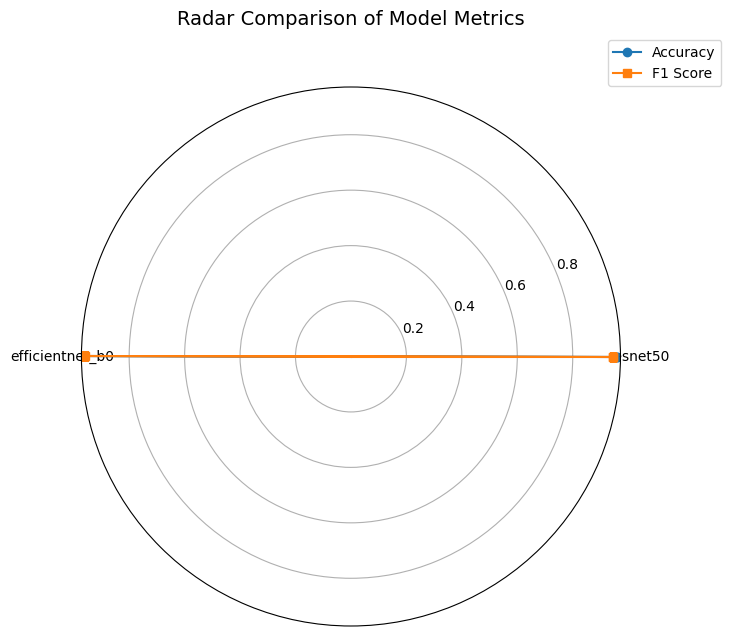

In [ ]:
from math import pi

categories = list(results.keys())
N = len(categories)

values_acc = [results[m]["accuracy"] for m in categories]
values_f1  = [results[m]["f1"] for m in categories]
values_acc += values_acc[:1]
values_f1  += values_f1[:1]

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(7,7))
plt.polar(angles, values_acc, marker='o', label="Accuracy")
plt.polar(angles, values_f1, marker='s', label="F1 Score")

plt.fill(angles, values_acc, alpha=0.2)
plt.fill(angles, values_f1, alpha=0.2)

plt.xticks(angles[:-1], categories)
plt.title("Radar Comparison of Model Metrics", size=14, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()
